In [1]:
import numpy as np
import pandas as pd
from src2.data_loader import *
# from src.strategy import *
from src2.index import *
from src2.strategy2 import *
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score,  classification_report
from fredapi import Fred
from keras.callbacks import EarlyStopping , ModelCheckpoint

from keras.models import Sequential # deep learning model
from keras.layers import LSTM, Dropout, Dense, Activation, GRU, Flatten
from keras import optimizers # 옵티마이저 

import datetime
import tensorflow as tf
import pandas_datareader as pdr
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
data = DataGenerator(data_type='db').data_search(ticker='AAPL')
data.sort_index(ascending=True, inplace=True)
data3 = data.copy()
data3.sort_index(ascending=True, inplace=True)

기존 데이터 불러오기 성공


In [3]:
data.columns = ["open","high","low","close","adjClose","volume"]

In [4]:
# data = data.loc["2010-09-16":"2022-10-11"]
# news = pd.read_csv("./BAC.csv", index_col=0)
# news = news[["label"]]
# news.index.rename("Datetime", inplace=True)
# data["label"] = news["label"]
# data.fillna(method="ffill", inplace=True)

In [5]:
data.columns

Index(['open', 'high', 'low', 'close', 'adjClose', 'volume'], dtype='object')

In [6]:
def add_feature(df, **kwargs):
    
    fred = Fred(api_key='d929757b1ad9cd1d5115620a50badb0a')
    
    data = df.copy()

    # data["Log_Close"]                              = np.log(data["adjClose"])
    data["AC_pct"]                                 = data['adjClose'].pct_change()
    data["V_pct"]                                  = data['volume'].pct_change()
    data["sma(5)"]                                 = sma(data, 5)
    data["sma(20)"]                                = sma(data, 20)
    data["High_Yield"]                             = fred.get_series('BAMLH0A0HYM2', data.index[0]).fillna(method="ffill")
    data["volume_sma5"]                            = data["volume"].rolling(5).mean()
    data["volume_sma20"]                           = data["volume"].rolling(20).mean()
    data["T10Y2Y"]                                 = fred.get_series('T10Y2Y', data.index[0])
    data["VIX"]                                    = fred.get_series('VIXCLS', data.index[0])
    data["RSI"]                                    = rsi(data, **kwargs)
    data[["macd","macd_signal","macd_oscillator"]] = macd(data, **kwargs)
    data["diff"]                                   = data["adjClose"].diff()
    data["vdiff"]                                  = data["volume"].diff()
#-------------------------------------------------------------------------------------------------------------------------------------------
    
    OBV = []
    OBV.append(0)
    for i in range(1, len(data['adjClose'])):
        if data['adjClose'][i] > data['adjClose'][i-1]: 
            OBV.append(OBV[-1] + data['volume'][i]) 
        elif data['adjClose'][i] < data['adjClose'][i-1]:
            OBV.append( OBV[-1] - data['volume'][i])
        else:
         OBV.append(OBV[-1])
    data['OBV'] = OBV
    data["OBV_mv20"] = data["OBV"].rolling(20).mean()
    
    #-------------------------------------------------------------------------------------------------------------------------------------------
    
    data.dropna(axis=0, inplace=True)
    # data.drop(["open","high","low","close","adjClose","tt","m_signal","r_signal","trend","macd_oscillator","macd_signal","volume_sma5","sma_signal","OBV"], axis=1, inplace=True)
    data.drop(["open","high","low","close","volume_sma5","macd_oscillator","macd_signal"], axis=1, inplace=True)
    return data

In [7]:
data.columns

Index(['open', 'high', 'low', 'close', 'adjClose', 'volume'], dtype='object')

In [8]:
data = add_feature(data)

In [9]:
data

,adjClose,volume,AC_pct,V_pct,sma(5),sma(20),High_Yield,volume_sma20,T10Y2Y,VIX,RSI,macd,diff,vdiff,OBV,OBV_mv20
Datetime,,,,,,,,,,,,,,,,
1996-12-31,0.158877,3.837456e+08,-0.040227,0.465797,0.170293,0.178855,3.13,198625280.0,0.55,20.92,29.925113,-0.01,-0.006659,1.219456e+08,5.172496e+09,5.927928e+09
1997-01-02,0.159828,1.431136e+08,0.005988,-0.627061,0.167059,0.177286,3.06,192004400.0,0.57,21.14,31.258498,-0.01,0.000951,-2.406320e+08,5.315610e+09,5.869132e+09
1997-01-03,0.165536,1.197168e+08,0.035712,-0.163484,0.165156,0.176049,3.09,188448960.0,0.57,19.13,38.784869,-0.01,0.005708,-2.339680e+07,5.435326e+09,5.825862e+09
1997-01-06,0.136044,1.882832e+09,-0.178160,14.727383,0.157164,0.173338,3.10,275483600.0,0.57,19.89,24.101400,-0.01,-0.029492,1.763115e+09,3.552494e+09,5.688451e+09
1997-01-07,0.133190,9.769312e+08,-0.020977,-0.481137,0.150695,0.170436,3.10,312860800.0,0.59,19.35,23.186625,-0.01,-0.002854,-9.059008e+08,2.575563e+09,5.490724e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-08,139.500000,8.990850e+07,0.004175,0.078368,140.047964,144.633145,4.79,93308430.0,-0.53,25.54,42.133239,-1.80,0.580002,6.533900e+06,1.398629e+11,1.399760e+11
2022-11-09,134.869995,7.491780e+07,-0.033190,-0.166733,138.064001,144.471101,4.99,93532635.0,-0.49,26.09,37.559833,-2.36,-4.630005,-1.499070e+07,1.397880e+11,1.399759e+11
2022-11-10,146.869995,1.188540e+08,0.088975,0.586459,139.707999,144.676940,4.80,93814135.0,-0.52,23.53,52.078579,-1.82,12.000000,4.393620e+07,1.399068e+11,1.399761e+11


In [10]:
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics

In [11]:
# 타겟값 분리
X = data.drop('adjClose', axis=1)
y = data[['adjClose']]

In [12]:
# 스탠다드 스케일러 사용 단, 타겟값은 적용하지 않음
ms = MinMaxScaler()
X  = ms.fit_transform(X)
# y  = ms.fit_transform(y)

In [13]:
X = pd.DataFrame(X, columns=data.drop("adjClose", axis=1).columns, index=data.index)
# y = pd.DataFrame(y, columns=data[["adjClose"]].columns, index=data.index)

In [14]:
X_train, X_test = X.iloc[:-36, :], X.iloc[-36 :]
y_train, y_test = y.iloc[:-36, :], y.iloc[-36:, :]

In [15]:
X_test.shape

(36, 15)

In [16]:
# 강사님의 윈도우 코드 복붙(이건 우리 입맛에 나중에 바꿔도 상관없음)
def my_window_data(feature,target, window_size=20):
    data = pd.concat([feature,target], axis = 1)
    X_list = []
    y_list = []
    for i in range(len(data) - window_size-2):
        X = data.iloc[i:i+window_size]
        y = target.iloc[i+window_size:i+window_size+2]
        X_list.append(np.array(X))      #[[] ,[] ,[] ,[]]
        y_list.append(np.array(y))       #[]   
    return  np.array(X_list), np.array(y_list)

In [17]:
X_train, y_train = my_window_data(X_train, y_train)
X_test , y_test = my_window_data(X_test , y_test)

In [18]:
X_train.shape, y_train.shape

((6404, 20, 16), (6404, 2, 1))

In [19]:
X_test.shape, y_test.shape

((14, 20, 16), (14, 2, 1))


# 모델

## GRU

In [20]:
BATCH = 20
EPOCH = 100

In [21]:
model_path = f'./model_2021/LSTM.h5'
checkpoint = ModelCheckpoint(filepath=model_path ,
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출됩니다
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                            )

early_stopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=10,         # 10회 Epoch동안 개선되지 않는다면 종료
                             )

In [22]:
with tf.device("/gpu:0"):
    model_GRU = Sequential()
    model_GRU.add(GRU(50,  return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    # model_GRU.add(Dense(128))
    model_GRU.add(Dropout(0.2))
    model_GRU.add(GRU(64))
    model_GRU.add(Dropout(0.2))
    # model_GRU.add(GRU(32))
    # model_GRU.add(Dropout(0.2))
    model_GRU.add(Dense(units = 2 ))

    adam = optimizers.Adam(lr = 0.001)

    model_GRU.compile(optimizer='adam', loss='mean_squared_error')

    model_GRU.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 50)            10200     
                                                                 
 dropout (Dropout)           (None, 20, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 64)                22272     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 32,602
Trainable params: 32,602
Non-trainable params: 0
_________________________________________________________________


In [23]:
hist_GRU = model_GRU.fit(X_train, y_train
                  , batch_size=BATCH
                  , epochs=EPOCH # 
                  , validation_data=(X_test, y_test)
                  , callbacks= [checkpoint,early_stopping]
                 )

history_GRU = model_GRU.evaluate(X_test, y_test)

Epoch 1/100
320/321 [============================>.] - ETA: 0s - loss: 1608.6226
Epoch 1: val_loss improved from inf to 14836.21289, saving model to ./model_2021\LSTM.h5
321/321 [==============================] - 5s 6ms/step - loss: 1609.9951 - val_loss: 14836.2129
Epoch 2/100
320/321 [============================>.] - ETA: 0s - loss: 1133.9594
Epoch 2: val_loss improved from 14836.21289 to 11525.51367, saving model to ./model_2021\LSTM.h5
321/321 [==============================] - 2s 5ms/step - loss: 1136.5571 - val_loss: 11525.5137
Epoch 3/100
320/321 [============================>.] - ETA: 0s - loss: 854.6006
Epoch 3: val_loss improved from 11525.51367 to 8926.76367, saving model to ./model_2021\LSTM.h5
321/321 [==============================] - 1s 5ms/step - loss: 854.0669 - val_loss: 8926.7637
Epoch 4/100
316/321 [============================>.] - ETA: 0s - loss: 650.4312
Epoch 4: val_loss improved from 8926.76367 to 6855.82520, saving model to ./model_2021\LSTM.h5
321/321 [======

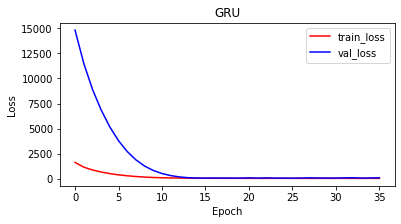

In [24]:
plt.style.use("grayscale")
plt.figure(figsize=(6,3))
plt.plot(hist_GRU.history["loss"], label="train_loss", color='r')
plt.plot(hist_GRU.history["val_loss"], label="val_loss", color='b')
plt.title("GRU")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

In [25]:
pred_GRU = model_GRU.predict(X_test)
print(pred_GRU)

1/1 [==============================] - 0s 431ms/step
[[149.86655 149.72707]
 [151.6182  151.46909]
 [153.86975 153.7141 ]
 [153.9134  153.78099]
 [151.82932 151.73592]
 [154.87318 154.74603]
 [156.25714 156.13573]
 [156.0079  155.9057 ]
 [153.01196 152.94627]
 [149.09323 149.05257]
 [147.69398 147.66092]
 [147.8951  147.83981]
 [147.71951 147.65024]
 [144.77441 144.72806]]


In [26]:
class backtest:
    def __init__(self, df ,position, result_show =False):
        self.df =df
        self.position = position
        self.result_show = result_show
        self.df = self.evaluate(self.df, cost=.001)
        self.performance(self.df)


    def __get_period(self, df):

        df.dropna(inplace=True)
        end_date = df['Datetime'].iloc[-1]
        start_date = df['Datetime'].iloc[0]
        days_between = (end_date - start_date).days
        return abs(days_between)
    def __annualize(self, rate, period):
        if period < 360:
            rate = ((rate-1) / period * 365) + 1
        elif period > 365:
            rate = rate ** (365 / period)
        else:
            rate = rate
        return round(rate, 4)


    def __get_sharpe_ratio(self, df, rf_rate):
        '''
        Calculate sharpe ratio
        :param df:
        :param rf_rate:
        :return: Sharpe ratio
        '''
        period = self.__get_period(df)
        rf_rate_daily = rf_rate / 365 + 1
        df['exs_rtn_daily'] = df['daily_rtn'] - rf_rate_daily
        exs_rtn_annual = (self.__annualize(df['acc_rtn'][-1:], period) - 1) - rf_rate
        exs_rtn_vol_annual = df['exs_rtn_daily'].std() * np.sqrt(365)
        sharpe_ratio = exs_rtn_annual / exs_rtn_vol_annual if exs_rtn_vol_annual>0 else 0
        return round(sharpe_ratio, 4)
    def evaluate(self, df, cost= .1):
        '''
        Calculate daily returns and MDDs of portfolio
        :param df: The dataframe containing trading position
        :param cost: Transaction cost when sell
        :return: Returns, MDD
        '''
        df['signal_price'] = np.nan
        df['signal_price'].mask(df[self.position]== 1, df['Adj Close'], inplace=True)
        df['signal_price'].mask(df[self.position]== 2, df['Adj Close'], inplace=True)
        record = df[[self.position,'signal_price']].dropna()
        record['rtn'] = 1
        record['rtn'].mask(record[self.position]== 2, (record['signal_price']*(1-cost))/record['signal_price'].shift(1), inplace=True)
        record['acc_rtn'] = record['rtn'].cumprod()

        df['signal_price'].mask(df[self.position]== 0, df['Adj Close'], inplace=True)
        df['rtn'] = record['rtn']
        df['rtn'].fillna(1, inplace=True)

        df['daily_rtn'] = 1
        df['daily_rtn'].mask(df[self.position] == 0, df['signal_price'] / df['signal_price'].shift(1), inplace=True)
        df['daily_rtn'].mask(df[self.position] == 2, (df['signal_price']*(1-cost)) / df['signal_price'].shift(1), inplace=True)
        df['daily_rtn'].fillna(1, inplace=True)
        df['acc_rtn'] = df['daily_rtn'].cumprod()
        df['acc_rtn_dp'] = ((df['acc_rtn']-1)*100).round(2)
        df['mdd'] = (df['acc_rtn'] / df['acc_rtn'].cummax()).round(4)
        df['bm_mdd'] = (df['Adj Close'] / df['Adj Close'].cummax()).round(4)
        df.drop(columns='signal_price', inplace=True)
        return df


    def performance(self, df, rf_rate=.01):
        '''
        Calculate additional information of portfolio
        :param df: The dataframe with daily returns
        :param rf_rate: Risk free interest rate
        :return: Number of trades, Number of wins, Hit ratio, Sharpe ratio, ...
        '''

        rst = {}
        rst['no_trades'] = (df[self.position]==1).sum()
        rst['no_win'] = (df['rtn']>1).sum()
        rst['acc_rtn'] = df['acc_rtn'][-1:].round(4)
        rst['hit_ratio'] = round((df['rtn']>1.0).sum() / rst['no_trades'], 4) if rst['no_trades']>0 else 0
        rst['avg_rtn'] = round(df[df['rtn']!=1.0]['rtn'].mean(), 4)
        rst['period'] = self.__get_period(df)
        rst['annual_rtn'] = self.__annualize(rst['acc_rtn'], rst['period'])
        rst['bm_rtn'] = round(df.iloc[-1,5]/df.iloc[0,5], 4)
        rst['sharpe_ratio'] = self.__get_sharpe_ratio(df, rf_rate)
        rst['mdd'] = df['mdd'].min()
        rst['bm_mdd'] = df['bm_mdd'].min()
        if self.result_show ==True:
            print('CAGR: ',round(rst['annual_rtn'].values[0] - 1,5))                       # 연간 수익
            print('Accumulated return:',round(rst['acc_rtn'].values[0] - 1,5))         # 
            print('Average return: ',round(rst['avg_rtn'] - 1,5))
            print('Benchmark return :',round(rst['bm_rtn']-1,5))
            print('Number of trades: ',(rst['no_trades']))
            print('Number of win:',(rst['no_win']))
            print('Hit ratio:',(rst['hit_ratio']))
            print('Investment period:',(rst['period']/365),'yrs')
            print('Sharpe ratio:',(rst['sharpe_ratio']))

            print('MDD:',(rst['mdd']-1)*100)
            print('Benchmark MDD:',(rst['bm_mdd']-1)*100)
            self.res = {'CAGR':(rst['annual_rtn'].values[0] - 1)*100,'Accumulated return':(rst['acc_rtn'].values[0] - 1)*100,'Average return': (rst['avg_rtn'] - 1)*100,'MDD':(rst['mdd']-1)*100}
        else:
            self.res = {'CAGR':(rst['annual_rtn'].values[0] - 1)*100,'Accumulated return':(rst['acc_rtn'].values[0] - 1)*100,'Average return': (rst['avg_rtn'] - 1)*100,'MDD':(rst['mdd']-1)*100}
            print('백테스팅 성공')

In [27]:
data_GRU = pd.DataFrame({"Adj Close":data.iloc[int(len(data) - len(pred_GRU)):]["adjClose"]})
# data_LSTM["volume"] = data.iloc[-14:]["volume"]

In [28]:
data_GRU["Adj Close"] = data3["Adj Close"][int(len(data)) - len(pred_GRU):]

In [29]:
data_GRU.reset_index(inplace=True)

In [30]:
data_GRU["pred"] = pred_GRU[:,0]
data_GRU["pred1"] = pred_GRU[:,1]

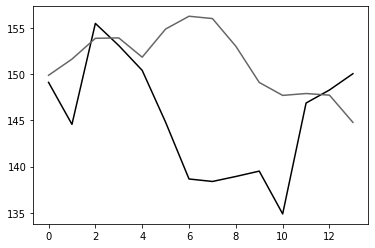

In [31]:
plt.plot(data_GRU["Adj Close"])
plt.plot(data_GRU["pred"])
# plt.plot(data_LSTM["pred1"])

In [32]:
signal = []
for idx in range(len(data_GRU['pred'])):
    if idx == 0 or idx+1 == len(data_GRU['pred']):
        signal.append(0)   
    else:
        if data_GRU['pred'].iloc[idx-2]> data_GRU['pred'].iloc[idx] and data_GRU['pred'].iloc[idx]> data_GRU['pred'].iloc[idx-1]:
            signal.append(1) #----- 상승
        elif data_GRU['pred'].iloc[idx-2]< data_GRU['pred'].iloc[idx] and data_GRU['pred'].iloc[idx]< data_GRU['pred'].iloc[idx-1]:
            signal.append(2) #----- 하락
        else:
            signal.append(0) #----- 횡보추세
data_GRU['position'] = signal

In [33]:
data_GRU

,Datetime,Adj Close,pred,pred1,position
0,2022-10-26,149.102661,149.866547,149.727066,0
1,2022-10-27,144.560196,151.618195,151.469086,0
2,2022-10-28,155.482086,153.869751,153.714096,0
3,2022-10-31,153.086044,153.913406,153.780991,0
4,2022-11-01,150.400497,151.829315,151.735916,0
5,2022-11-02,144.789810,154.873184,154.746033,0
6,2022-11-03,138.650009,156.257141,156.135727,0
7,2022-11-04,138.380005,156.007904,155.905701,2
8,2022-11-07,138.919998,153.011963,152.946274,0
9,2022-11-08,139.500000,149.093231,149.052567,0


Text(0.5, 1.0, 'Price')

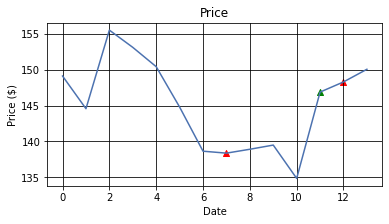

In [34]:
dummy_df = data_GRU
# 그림 사이즈 설정
plt.style.use("seaborn-deep")
plt.figure(figsize=(6,3))

# 종가 기준으로 차트를 그림
data_GRU['Adj Close'].plot(grid=True)

# position이 1 인경우 초록색으로 해당 종가에 표시
plt.scatter(dummy_df.loc[data_GRU.position == 1].index, dummy_df['Adj Close'][dummy_df.position == 1],
            color='green', 
            label='Buy', 
            marker = '^', 
            alpha=1)

# position이 -1 인경우 빨간색으로 해당 종가에 표시
plt.scatter(dummy_df.loc[dummy_df.position == 2].index, dummy_df['Adj Close'][dummy_df.position == 2],
            color='red', 
            label='Sell', 
            marker = '^', 
            alpha=1)

# # trend이 1 인경우 초록색으로 해당 종가에 표시
# plt.scatter(dummy_df.loc[df.trend == 1].index, dummy_df['Adj Close'][dummy_df.trend == 1],
#             color='pink', 
#             label='up', 
#             marker = 'o', 
#             alpha=0.5)

# # position이 -1 인경우 빨간색으로 해당 종가에 표시
# plt.scatter(dummy_df.loc[dummy_df.trend == 0].index, dummy_df['Adj Close'][dummy_df.trend == 0],
#             color='blue', 
#             label='down', 
#             marker = 'o', 
#             alpha=0.5)


plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.title('Price')

In [35]:
back_GRU = backtest(data_GRU,'position',True)

CAGR:  -1.4198
Accumulated return: -0.0778
Average return:  0.0086
Benchmark return : 0.0
Number of trades:  1
Number of win: 1
Hit ratio: 1.0
Investment period: 0.0547945205479452 yrs
Sharpe ratio: 13   -2.535
Name: acc_rtn, dtype: float64
MDD: -13.339999999999996
Benchmark MDD: -13.260000000000005
